# Задание 1  
> Интерпретация задачи "Найти в тексте на русском языке факт продажи."

Под фактом продажи я понимаю фрагмент текста, который несет **"продающий" смысл — рекламный контент**.  
Ставлю перед собой цель — выделить в тексте рекламную часть. Для этого я разделяю задачу на следующие этапы:  
1. Классифицировать текст как содержащий рекламу или не содержащий рекламу.  
2. Найти рекламный фрагмент в тексте, который был классифицирован как рекламосодержащий.


## 1. Проблема с данными  
Первая проблема, с которой я столкнулась — это отсутствие подходящего датасета на русском языке, а также неравномерность классов: большинство статей не рекламные, а также новостные издания часто не указывают в очевидном месте, является ли статья к рекламой.

### Решение - свой датасет  
Для решения этой задачи я создала собственный датасет, взяв за основу новости с сайта Lenta.ru ([ссылка на Kaggle](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta)). Чтобы дополнить его рекламными материалами, я внедрила рекламные элементы в обычные новости с помощью Yandex GPT. Скрипты для создания и обработки датасета можно найти в папке `\dateset_generation`.


In [1]:
import pandas as pd

news = pd.read_csv("data/final_dataset.csv")
news = news.sample(frac=1)
news.head()

,title,text,label,url
1210,NaN,В Казани с 10 по 12 ноября прошла международна...,1,generated
3662,NaN,\nКаждый день люди сталкиваются с неопределённ...,1,generated
6004,Предсказано катастрофическое появление «чернею...,Астрофизики из Университета штата Оклахома обн...,0,https://lenta.ru/news/2017/08/21/dwarf/
1721,Концерт в Екатеринбурге: встреча с прекрасным ...,"В Екатеринбурге состоится грандиозный концерт,...",1,generated
6925,Фуркад отказался пожимать руку Логинову и ушел...,Французский биатлонист Мартен Фуркад демонстра...,0,https://lenta.ru/news/2017/02/09/login/


## 2. Предобработка данных

In [5]:
from sklearn.model_selection import train_test_split

X = news["text"]
y = news["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
import pymorphy2
import re


class DataPreprocessor:
    def __init__(self):
        nltk.download("stopwords")

        self.my_stopwords = stopwords.words("russian")
        self.my_stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

        self.morph = pymorphy2.MorphAnalyzer()

    def stemming(self, content):
        stemmed_content = re.sub('[^а-яА-Я]', ' ', content)  
        stemmed_content = stemmed_content.lower() 
        stemmed_content = stemmed_content.split()  
        return ' '.join([self.morph.parse(token)[0].normal_form for token in stemmed_content if
                         token not in self.my_stopwords and token])

    def fit_transform(self, X: pd.Series) -> pd.Series:
        return X.apply(self.stemming)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import umap.umap_ as umap

### Снижаю размерность и смотрю как представлены данные
> Для снижения размерности использую umap

In [10]:
def vectorize(vectorizer, X_train, X_test):
    preprocessor = DataPreprocessor()
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.fit_transform(X_test)
    vectorizer.fit(X_train)

    bow = vectorizer.transform(X_train)
    bow_test = vectorizer.transform(X_test)

    print(bow.shape)

    scaler = MaxAbsScaler()
    reducer = umap.UMAP(n_neighbors=15, n_components=2)
    embedding = reducer.fit_transform(bow)

    plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap="bwr")
    plt.title('UMAP Projection of Random Data')
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.legend()
    plt.show()
    return {"train": scaler.fit_transform(bow),
            "test": scaler.transform(bow_test)}


def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(classification_report(y_test, pred))

#### Визуализируем расположение разных классов

[nltk_data] Downloading package stopwords to /home/sofia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(7549, 279)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


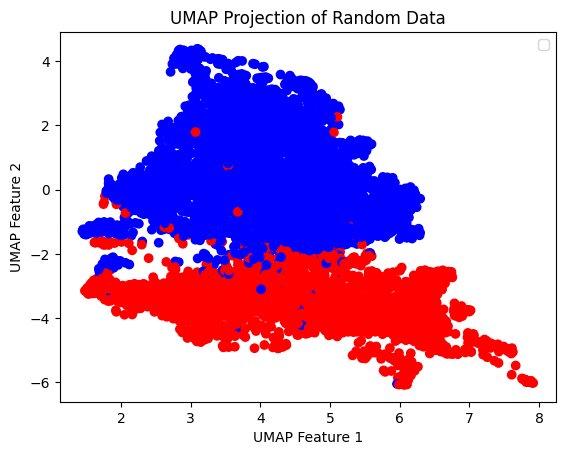

[nltk_data] Downloading package stopwords to /home/sofia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(7549, 279)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


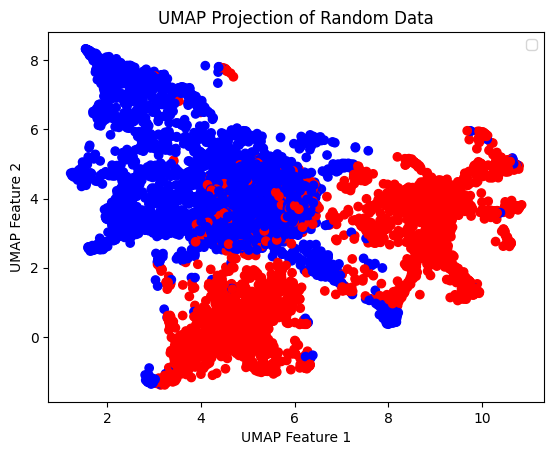

In [6]:
vectorizers = {
    "CountVectorizer": CountVectorizer(ngram_range=(1, 1), min_df=0.05, max_df=0.8),
    "TfidfVectorizer": TfidfVectorizer(ngram_range=(1, 1), min_df=0.05, max_df=0.8),
}

vectorized_data = {vectorizer_name: vectorize(vectorizers[vectorizer_name], X_train, X_test) for vectorizer_name in
                   vectorizers}


## 3.1. Выбор модели  
Для решения задачи я решила протестировать несколько моделей, каждая из которых использует разный подход к классификации:

- `Logistic Regression` — хорошо работает для бинарной классификации.
- `Random Forest Classifier` — устойчива к переобучению и может работать с большим количеством признаков.
- `SVC (Support Vector Classifier)` — может обрабатывать нелинейные зависимости.
- `CatBoost Classifier` — может автоматически обрабатывать категориальные признаки без необходимости их предварительного кодирования.

In [23]:
from sklearn.metrics import accuracy_score, f1_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    "SVC": SVC(kernel="linear", class_weight='balanced', random_state=42),
    "CatBoostClassifier": CatBoostClassifier(iterations=100, random_state=42, silent=True),
}

for model_name, model in models.items():
    for vectorizer_name, vectorizer in vectorizers.items():
        X_train_vect = vectorizer.fit_transform(X_train)
        X_test_vect = vectorizer.transform(X_test)
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        print(f"Model: {model_name} ({vectorizer_name}), Accuracy: {accuracy_score(y_test, y_pred)}, F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

Model: LogisticRegression (CountVectorizer), Accuracy: 0.9960270162892332, F1 Score: 0.9960270162892332
Model: LogisticRegression (TfidfVectorizer), Accuracy: 0.9964243146603099, F1 Score: 0.9964240659010113
Model: RandomForestClassifier (CountVectorizer), Accuracy: 0.9968216130313866, F1 Score: 0.9968220519877493
Model: RandomForestClassifier (TfidfVectorizer), Accuracy: 0.9976162097735399, F1 Score: 0.9976162097735399
Model: SVC (CountVectorizer), Accuracy: 0.9916567342073898, F1 Score: 0.9916549842672033
Model: SVC (TfidfVectorizer), Accuracy: 0.9964243146603099, F1 Score: 0.9964245621884611
Model: CatBoostClassifier (CountVectorizer), Accuracy: 0.9948351211760031, F1 Score: 0.994834761857016
Model: CatBoostClassifier (TfidfVectorizer), Accuracy: 0.9948351211760031, F1 Score: 0.9948333067759247


#### **Вывод**:  
Все модели показывают хороший результат. Как было заметно на карте фич сверху, классы легко разделяются даже линейной моделью.  
Я предположу, что генерированные тексты с рекламой построены по особому, чем новостные тексты, и поэтому легко выделяются. 
Дальше сравним ещё кастомноую LSTM модель и попробуем выделять фразы с рекламой.

In [8]:
preprocessor = DataPreprocessor()

[nltk_data] Downloading package stopwords to /home/sofia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.2. Сравнение с кастомной LSTM моделью 
Я еще решила протестировать кастомную lstm помимо тех моделей. LSTM лучше умеет учитывать контекст слов в тексте.

In [220]:
lstm_n = pd.DataFrame()
lstm_n["text"] = preprocessor.fit_transform(news["text"])
lstm_n["label"] = news["label"]
lstm_n

,text,label
1210,казань ноябрь пройти международный научный кон...,1
3662,каждый день человек сталкиваться неопредел нно...,1
6004,астрофизик университет штат оклахома обнаружит...,0
1721,екатеринбург состояться грандиозный концерт ко...,1
6925,французский биатлонист мартен фуркад демонстра...,0
...,...,...
7081,сеть появиться первый трейлер фильм предчувств...,0
6877,капитан махачкалинский футбольный клуб анжи ро...,0
3401,стратегический календарь инновационный продукт...,1
6582,форвард сборная россия хоккей александр радуло...,0


In [221]:
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace

x_train, x_test, y_train, y_test = train_test_split(lstm_n['text'].values, lstm_n["label"].values, test_size=0.2, random_state=434)

tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

tokenizer.train_from_iterator(
    x_train,
    vocab_size=5_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

In [224]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels
        self.max_len = max_len


    def __len__(self):
        return len(self.tokens)


    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(int(label))
        tokens = self.tokens[idx]
        out = torch.zeros(self.max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:self.max_len]
        return out, label

In [ ]:
train_tokens = [tokenizer.encode(str(text)).ids for text in list(x_train)]
test_tokens = [tokenizer.encode(str(text)).ids for text in list(x_test)]
train_tokens

График для оценки длин списков токенов

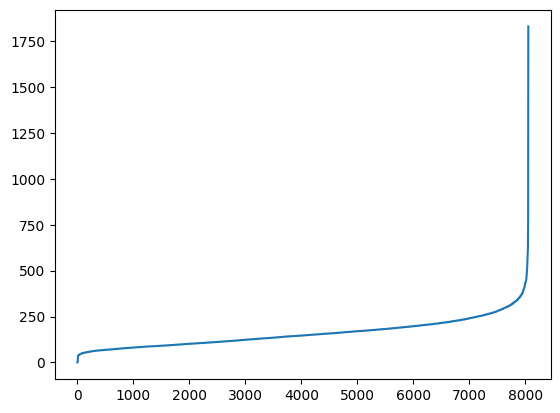

In [226]:
plt.plot(sorted([len(arr) for arr in train_tokens]))

In [227]:
BATCH_SIZE = 32
max_len = 1000

train_dataset = TextDataset(train_tokens, y_train, 1000)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TextDataset(test_tokens, y_test, 1000)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Класс модели
сам слой лстм + слои для предобработки, нормализации и регуляризации

In [228]:
class LSTM_classifier(nn.Module):
    def __init__(self, hidden_dim=128, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.3, n_classes=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [261]:
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='binary')
    return score, predicted

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [262]:
from tqdm import tqdm 
def train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=20):
    best_score = 0
    for epoch in tqdm(range(epochs)):
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        score, _ = eval_nn(model, test_loader)
        print(epoch, 'valid:', score)
        if score > best_score:
            torch.save(model.state_dict(), 'lstm.pt')
            best_score = score
    return best_score

model = LSTM_classifier(hidden_dim=256, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.1)   

In [264]:
model.apply(init_weights)
model.to(device)

LSTM_classifier(
  (embedding_layer): Embedding(5000, 300)
  (lstm_layer): LSTM(300, 256, batch_first=True, bidirectional=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (fc_layer): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (out_layer): Linear(in_features=128, out_features=2, bias=True)
)

In [267]:
optimizer = optim.AdamW(model.parameters())
loss_function = nn.CrossEntropyLoss().to(device)

train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=1)

100%|█████████████████████████████████████████| 252/252 [00:20<00:00, 12.18it/s]


0 valid: 0.9599012954966071

100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.69s/it]


0.9599012954966071

In [268]:
_, preds = eval_nn(model, test_loader)
print(classification_report(y_test, preds))

precision    recall  f1-score   support

           0       0.96      0.98      0.97      1190
           1       0.98      0.94      0.96       824

    accuracy                           0.97      2014
   macro avg       0.97      0.96      0.97      2014
weighted avg       0.97      0.97      0.97      2014

#### **Вывод**:  
Результат тоже хороший. В моём случае можно использовать любую модель для классификации.

## 4. Поиск факта продажи в тексте
После того, как мы определили, присутствует ли реклама в тексте, перейдем к нахождению ее места. Так как это задача NER, в первую очередь я начала искать русскоязычные модели. Большинство из них содержат только теги LOC, ORG, PER и работают с невысокой точностью. Датасета для определения места рекламы в тексте я не нашла, а при разметке с помощью ЛЛМ случались казусы со съездом разметки.

Так мне пришла идея, искать тег организации в тексте, что это скорее всего будет показывать место, где продают товар/событие. Однако многие из моделей (такие как scipy, natasha, ner_slav_bert) работают через раз на моем датасете. Потом я подумала искать по ключевым словам вроде "приобретите", "попробуйте", но отказалась от этой идеи так так могу упустить возможные места рекламы.

Потом я проанализировала текста в датасете и заметила, что многие содержат Call-to-action. Я нашла только немецкую языковую версию берта, чтобы классифицировать побуждающие предложения.

**Моя конечная идея:**
1. Прогоняю текст через классификатор рекламы
2. Положительно классифицированные прогоняю через немецкий берт на предмет побуждения к действию (купить, посетить, пользоваться)
3. Если предыдущий пункт ничего не дал, то ищу имя организации (с помощью русской scipy) и выбираю предложение с ним
4. при ненахождении оставляю как есть.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import nltk
nltk.download('punkt') 
from nltk.tokenize import sent_tokenize
from deep_translator import GoogleTranslator
import spacy
from rich import print

tokenizer_ge = BertTokenizer.from_pretrained('chaichy/gbert-CTA-w-synth')
model_ge = BertForSequenceClassification.from_pretrained('chaichy/gbert-CTA-w-synth')

nlp = spacy.load("ru_core_news_sm")
X = news["text"]
y = news["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model_base = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_base.fit(vectorized_data[vectorizer_name]['train'], y_train)

In [273]:
def check(text, tokenizer_ge, model_ge, model_base, vectorizer):
    passed = False
    sentences = sent_tokenize(text)
    sentence_pairs = [(sentence, 0) for sentence in sentences]
    vectorizer = vectorizers["CountVectorizer"] 
    sentence_vec = vectorizer.transform([text]) 
    
    prediction = model_base.predict(sentence_vec)

    
    if prediction[0] == 0:
        return sentence_pairs
    # call to action
    for i in range(len(sentence_pairs)):
        inputs = tokenizer_ge(GoogleTranslator(source='russian', target='german').translate(sentence_pairs[i][0]), return_tensors="pt")
        outputs = model_ge(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        if predicted_class:
            passed = True
            sentence_pairs[i] = (sentence_pairs[i][0], predicted_class)
    if passed:
        return sentence_pairs
    # tags
    for i in range(len(sentence_pairs)):
        doc = nlp(sentence_pairs[i][0])
        for ent in doc.ents:
            if ent.label_ == "ORG":
                passed = True
                sentence_pairs[i] = (sentence_pairs[i][0], 1)
    if passed:
        return sentence_pairs

def pretty_print(sentence_pairs):
    output = " ".join([f"[green]{text}[/green]" if flag == 1 else f"[white]{text}[/white]" for text, flag in sentence_pairs])
    print(output)

### Возьмём эти четыре текста в качестве демонстрации и прогоним через модель

In [30]:
request_text_0 = """Казань, столица Татарстана, вновь встречает лучших молодых поэтов страны. В этом городе с богатой литературной историей пройдёт конкурс молодых поэтов, в котором будут выбраны лучшие из лучших.
Организаторы конкурса приглашают всех поэтов от 18 до 35 лет принять участие в этом грандиозном событии. Поэты могут предоставить на суд жюри свои лучшие работы, которые будут оценены по таким критериям, как оригинальность, мастерство исполнения и глубина мысли.
Победители конкурса получат возможность опубликовать свои стихи в новом сборнике, который будет выпущен к концу года. Сборник станет настоящим подарком для ценителей поэзии и будет включать лучшие произведения современных поэтов.
Также для участников конкурса и гостей мероприятия будет организована выставка-продажа книг издательства «Поэзия Татарстана». Здесь можно будет найти сборники стихов современных авторов, а также произведения классиков татарской литературы.
Конкурс молодых поэтов обещает стать ярким событием в культурной жизни Казани. Он откроет новые имена и даст возможность молодым поэтам заявить о себе на всю страну. А пока остаётся только ждать результатов конкурса и следить за новостями.
"""
request_text_1 = """  В Тюмени появилась уникальная возможность для владельцев автомобилей LADA! Теперь вы можете провести бесплатную диагностику своего автомобиля и быть уверенными в его надёжности.

Это замечательное предложение от сервиса «Автодом» позволит вам убедиться в отличном состоянии вашего авто и получить рекомендации для дальнейшего обслуживания.

Специалисты сервиса проведут тщательный осмотр всех систем и агрегатов, включая двигатель, трансмиссию, подвеску, рулевое управление, тормозную систему и электрику. Вы сможете узнать о состоянии и ресурсе вашего автомобиля, а также получить профессиональные рекомендации по замене запчастей и комплектующих.

Не упустите возможность воспользоваться уникальным предложением и провести качественную диагностику своего авто. Не откладывайте заботу о своём автомобиле на потом, сделайте это уже сейчас!"""
request_text_2 = """Праздник весны в Китае – это время ярких красок, безудержного веселья и, конечно же, подарков! В эти дни принято дарить близким сувениры, которые будут напоминать о тёплых семейных встречах.

В этом году праздник обещает быть особенно радостным и запоминающимся. Ведь к нему можно подготовиться заранее – подобрать уникальные и оригинальные сувениры от PartyGoods. Они станут идеальным подарком для друзей и близких, а также будут радовать их долгое время.
z
Сувениры от PartyGoods созданы с любовью и заботой о каждом клиенте. Они сочетают в себе высокое качество, уникальный дизайн и доступную цену. """
request_text_3 = """Нью-Йорк, 23 ноября 2023 года. В преддверии Дня благодарения в Нью-Йорке состоится викторина по истории США. В интеллектуальном соревновании смогут принять участие все желающие. Викторина позволит проверить свои знания и узнать много нового о жизни в Соединённых Штатах.
Вопросы будут касаться всех периодов американской истории. Участники смогут проявить свою эрудицию и сообразительность. А самые удачливые — получить ценные призы.
Имена победителей будут опубликованы в социальных сетях организаторов.
Викторина проводится при поддержке бренда «Оригинальные сувениры», который подготовил особенные призы для участников. Среди подарков — уникальные исторические сувениры, которые позволят сохранить память об этом событии.
Не упустите возможность проверить свои знания, интересно провести время и получить ценные призы!
"""


0. Текст не являющийся рекламой

In [279]:
pretty_print(check(request_text_0,tokenizer_ge, model_ge, model_base, vectorizers["CountVectorizer"]))

Казань, столица Татарстана, вновь встречает лучших молодых поэтов страны. В этом городе с богатой литературной 
историей пройдёт конкурс молодых поэтов, в котором будут выбраны лучшие из лучших. Организаторы конкурса приглашают
всех поэтов от 18 до 35 лет принять участие в этом грандиозном событии. Поэты могут предоставить на суд жюри свои 
лучшие работы, которые будут оценены по таким критериям, как оригинальность, мастерство исполнения и глубина мысли.
Победители конкурса получат возможность опубликовать свои стихи в новом сборнике, который будет выпущен к концу 
года. Сборник станет настоящим подарком для ценителей поэзии и будет включать лучшие произведения современных 
поэтов. Также для участников конкурса и гостей мероприятия будет организована выставка-продажа книг издательства 
«Поэзия Татарстана». Здесь можно будет найти сборники стихов современных авторов, а также произведения классиков 
татарской литературы. Конкурс молодых поэтов обещает стать ярким событием в культурной жизни Казани. Он откроет 
новые имена и даст возможность молодым поэтам заявить о себе на всю страну. А пока остаётся только ждать 
результатов конкурса и следить за новостями.

1. Реклама с побуждением к действию

In [278]:
pretty_print(check(request_text_1,tokenizer_ge, model_ge, model_base, vectorizers["CountVectorizer"]))

  В Тюмени появилась уникальная возможность для владельцев автомобилей LADA! Теперь вы можете провести бесплатную 
диагностику своего автомобиля и быть уверенными в его надёжности. Это замечательное предложение от сервиса 
«Автодом» позволит вам убедиться в отличном состоянии вашего авто и получить рекомендации для дальнейшего 
обслуживания. Специалисты сервиса проведут тщательный осмотр всех систем и агрегатов, включая двигатель, 
трансмиссию, подвеску, рулевое управление, тормозную систему и электрику. Вы сможете узнать о состоянии и ресурсе 
вашего автомобиля, а также получить профессиональные рекомендации по замене запчастей и комплектующих. Не упустите 
возможность воспользоваться уникальным предложением и провести качественную диагностику своего авто. Не 
откладывайте заботу о своём автомобиле на потом, сделайте это уже сейчас!

2. Реклама с названием организации

In [276]:
pretty_print(check(request_text_2,tokenizer_ge, model_ge, model_base, vectorizers["CountVectorizer"]))

Праздник весны в Китае – это время ярких красок, безудержного веселья и, конечно же, подарков! В эти дни принято 
дарить близким сувениры, которые будут напоминать о тёплых семейных встречах. В этом году праздник обещает быть 
особенно радостным и запоминающимся. Ведь к нему можно подготовиться заранее – подобрать уникальные и оригинальные 
сувениры от PartyGoods. Они станут идеальным подарком для друзей и близких, а также будут радовать их долгое время.
z
Сувениры от PartyGoods созданы с любовью и заботой о каждом клиенте. Они сочетают в себе высокое качество, 
уникальный дизайн и доступную цену.

3. Текст, классифицирован как рекламный, но **факт продажи не распознан**  

Можно отнести к факту продажи фразу: *`"бренда «Оригинальные сувениры», который подготовил особенные призы для участников."`*

In [277]:
pretty_print(check(request_text_3,tokenizer_ge, model_ge, model_base, vectorizers["CountVectorizer"]))

Нью-Йорк, 23 ноября 2023 года. В преддверии Дня благодарения в Нью-Йорке состоится викторина по истории США. В 
интеллектуальном соревновании смогут принять участие все желающие. Викторина позволит проверить свои знания и 
узнать много нового о жизни в Соединённых Штатах. Вопросы будут касаться всех периодов американской истории. 
Участники смогут проявить свою эрудицию и сообразительность. А самые удачливые — получить ценные призы. Имена 
победителей будут опубликованы в социальных сетях организаторов. Викторина проводится при поддержке бренда 
«Оригинальные сувениры», который подготовил особенные призы для участников. Среди подарков — уникальные 
исторические сувениры, которые позволят сохранить память об этом событии. Не упустите возможность проверить свои 
знания, интересно провести время и получить ценные призы!

### Выводы:
Модель вполне хорошо определяет отрывки содержашие факт продажи, а также название компаний. Тем не менее сложные случаи, как в тексте 3 она обнаружить не смогла.  
Помимо этого модель слабо работает на собственноручно написанных примерах, т.к была обучен на синтетическом датасете от яндекс гпт. Это стоит учитывать при применении модели к другого рода данным.

# 5. Сравнение с LLM YandexGPT

Так как для генерации датасета я уже использовала LLM YandexGPT, я решила протестировать, как это можель будет справляться и с поиском факта продажи.
Попробуем два варианта:
1. Выводить номера предложений, в которых присутствует факт продажи
2. Выводить индексы символов начала и конца фразы о продаже в тексте

In [26]:
from dataset_generation.gpt_wrapper import YandexGptApi

FOLDER_ID = 'YOUR_FOLDER_ID'     # TODO hide it
OAUTH_TOKEN = 'YOUR_OAUTH_TOKEN'   # TODO hide it
yandex_gpt = YandexGptApi(OAUTH_TOKEN, FOLDER_ID)

In [34]:
# Вариант 1:
def sequence_detect(request_text: str):
    instructions = ("Тебе на вход придёт текст с пронумерованными предложениями. Проанализируй его и выпиши\
        все предложения, в которых присутствует факт продажи. Укажи эти предложения отдельно и выведи только их,\
        не выводи лишнего. Для разделения используй символ '\n'."
    )

    sentences = re.split(r'(?<=[.!?])\s+', request_text)
    sentences = [s.strip() for s in sentences if s.strip()]
    numbered = [f"{i}. {sentence}" for i, sentence in enumerate(sentences)]
    number_request = '\n'.join(numbered)

    answer = yandex_gpt.completion(instructions, number_request, temperature=0.1)
    return answer

for i, request in enumerate([request_text_0,request_text_1,request_text_2,request_text_3]):
    print(f"Text {i}:")
    for line in sequence_detect(request).split('\n'):
        print(f"\t{line}")

Text 0:
	6. Также для участников конкурса и гостей мероприятия будет организована выставка-продажа книг издательства «Поэзия Татарстана».
Text 1:
	Факт продажи в этом тексте отсутствует.
Text 2:
	3. Ведь к нему можно подготовиться заранее – подобрать уникальные и оригинальные сувениры от PartyGoods.
	4. Они станут идеальным подарком для друзей и близких, а также будут радовать их долгое время.
Text 3:
	8. Викторина проводится при поддержке бренда «Оригинальные сувениры», который подготовил особенные призы для участников.
	9. Среди подарков — уникальные исторические сувениры, которые позволят сохранить память об этом событии.


In [45]:
# Вариант 2:
def interval_detect(request_text: str):
    instructions = ("Тебе на вход придёт текст, проанализируй его и на наличие факта продажи. Выведи отрывок\
        текста с фактом продажи и индексты начала и конца отрывка в тексте. Пример: ' Индексы: [15,45] Отрывок: Продаю гараж компании\
        Нивада!'. Не выводи лишнего."
    )

    answer = yandex_gpt.completion(instructions, request_text, temperature=0.2)
    return answer

for i, request in enumerate([request_text_0,request_text_1,request_text_2,request_text_3]):
    print(f"Text {i}:")
    for line in interval_detect(request).split('\n'):
        print(f"\t{line}")

Text 0:
	Индексы: [71, 80]
	Отрывок: Также для участников конкурса и гостей мероприятия будет организована выставка-продажа книг издательства «Поэзия Татарстана».
Text 1:
	Факта продажи в данном тексте нет.
Text 2:
	Индексы: [65, 83]
	Отрывок: Они станут идеальным подарком для друзей и близких, а также будут радовать их долгое время.
Text 3:
	Факта продажи в данном тексте нет.


## Вывод:  
При использовании LLM возникают много проблем с соблюдениев формата вывода, а также с выводом лишней информации. Помимо этого добиться выводить отрывок из текста не удалось.  
Однако этот способ имеет место быть, если требуется быстро приготовить решение.  

Не исключаю, что если подобрать более грамотный промпт, можно будет добиться лучших результатов.